In [1]:
import sys,os
os.chdir('../')
sys.path.append('./src/data')
sys.path.append('./src/events')
sys.path.append('./src/probability')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from functions import nufit_params_nsi, nufit_params_nsi_IO
from PINGU.event_processing import return_precomputed_nsi, to_hist
from PINGU.event_processing import get_deltachi as deltachi_PINGU
from DC.event_processing import get_param_list, list_of_params_nsi, get_best_fit
from DC.event_processing import get_deltachi as deltachi_DC
from DC.event_processing import get_marginalized_array as marginalize_DC
from PINGU.event_processing import get_marginalized_array as marginalize_PINGU
from IC.event_processing import get_deltachi as deltachi_IC
from IC.event_processing import normalize_events
from scipy.stats import chi2
import pickle
from scipy.interpolate import splrep, splev, sproot
from plotter import save, savethesis
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
np.set_printoptions(linewidth=200)

In [17]:
ndim = 3
livetime = 3*365*24*3600 #Effective livetime table1 DC2019 2.45
ordering = 'NO'
IO = False if ordering == 'NO' else True

dm31_range, th23_range,ett_range, emt_range, eem_range, eet_range = get_param_list(dm31N=5, 
                                                                                   th23N=5, 
                                                                          ett=5e-2, ettN=1, 
                                                                          emt=2e-2, emtN=1, 
                                                                          eem=2e-1, eemN=1, 
                                                                          eet=2e-1, eetN=10, 
                                                                          IO=IO)

In [18]:
param_dict = nufit_params_nsi_IO if ordering == 'IO' else nufit_params_nsi     
param_list = list_of_params_nsi(param_dict, dm31_range, th23_range,ett_range, emt_range, eem_range,eet_range) 

In [19]:
H1_DC = pickle.load(open(f'./pre_computed/H1_{ordering}_DC_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p','rb'))*livetime

H1_PINGU = pickle.load(open(f'./pre_computed/H1_{ordering}_PINGU_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p','rb'))*livetime

H0_PINGU = pickle.load(open(f'./pre_computed/H0_{ordering}_PINGU.p','rb'))*livetime


'''
H1_events_list = pickle.load(open(f'./pre_computed/H1_IC_N{N}_{len(emm_range)}x{len(s24_range)}x{len(emt_range)}.p','rb'))
H0_events = pickle.load(open(f'./pre_computed/H0_IC_N{N}_nsi.p','rb'))
H0_normalized, H1_list_normalized = normalize_events(H0_events,H1_events_list,np.arange(0,20))
H1_IC = np.array(H1_list_normalized)
'''

"\nH1_events_list = pickle.load(open(f'./pre_computed/H1_IC_N{N}_{len(emm_range)}x{len(s24_range)}x{len(emt_range)}.p','rb'))\nH0_events = pickle.load(open(f'./pre_computed/H0_IC_N{N}_nsi.p','rb'))\nH0_normalized, H1_list_normalized = normalize_events(H0_events,H1_events_list,np.arange(0,20))\nH1_IC = np.array(H1_list_normalized)\n"

In [20]:
sigma_a = 0.25
sigma_b = 0.04
f_PINGU = 0
f_DC = 1
f_IC = 0.1
marginalized_arrays_NO=[]
marginalized_arrays_IO=[]
nsi_param_range=[]


DC_chisq  = marginalize_DC(H1_DC,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'joint', sigma_a,sigma_b, f_DC)

PINGU_chisq = marginalize_PINGU(H1_PINGU,H0_PINGU,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'joint', sigma_a,sigma_b, f_PINGU)
#IC_chisq, best_indexIC, min_chi2_IC = deltachi_IC(H1_IC, None,np.linspace(-1e-2,1e-2,100),emm_range,0,[sigma_a,sigma_b],f_IC,x0=[1])


PINGU_deltachi = PINGU_chisq - PINGU_chisq.min()
DC_deltachi = DC_chisq - DC_chisq.min()
#IC_deltachi = IC_chisq - IC_chisq.min()
joint_chisq =  PINGU_chisq  + DC_chisq#+ IC_chisq
joint_deltachi = joint_chisq - joint_chisq.min()
#1-chi2.cdf(joint_chisq.min()- PINGU_chisq.min(),df=2) #idk

best_fit_index = np.argmin(joint_deltachi)
best_dm31_index,best_th23_index,best_ett_index,best_emt_index,best_eem_index,best_eet_index = np.unravel_index(best_fit_index,joint_deltachi.shape)

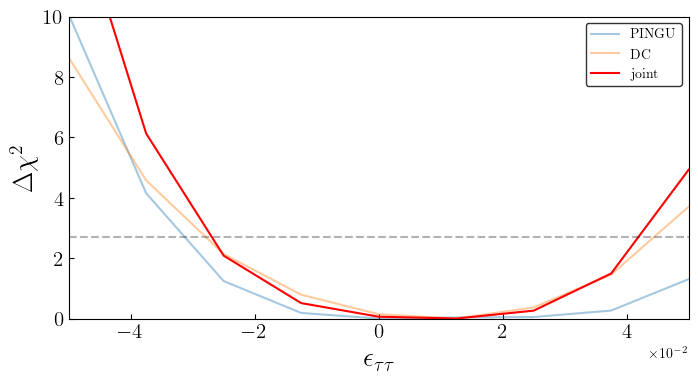

In [6]:
DC_marginalized_ett  = marginalize_DC(H1_DC,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'ett', sigma_a,sigma_b, f_DC)

PINGU_marginalized_ett = marginalize_PINGU(H1_PINGU,H0_PINGU,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'ett', sigma_a,sigma_b, f_PINGU)
joint_marginalized_ett = joint_deltachi[best_dm31_index,best_th23_index,:,best_emt_index,best_eem_index,best_eet_index]

fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(ett_range, PINGU_marginalized_ett,label='PINGU', alpha=0.4)
ax.plot(ett_range, DC_marginalized_ett,label='DC', alpha=0.4)
ax.plot(ett_range, joint_marginalized_ett,label='joint', color='red')
ax.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')

ax.set_ylim(bottom=0, top=10)
ax.set_xlim(-5e-2,5e-2)
ax.set_xlabel(r'$\epsilon_{\tau\tau}$', fontsize=20)
ax.set_ylabel(r'$\Delta \chi^2$', fontsize=20)
ax.tick_params(labelsize=15)
leg=plt.legend()
leg.get_frame().set_edgecolor('k')
ax.tick_params(axis='both', direction='in', which='both')
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
#save(fig, 'joint_3D_ett')

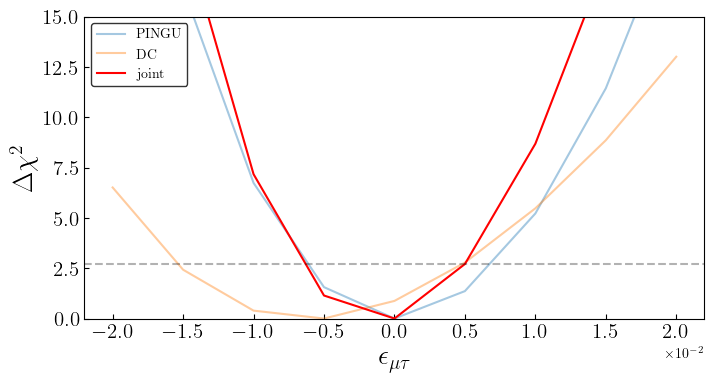

In [11]:
DC_marginalized_emt  = marginalize_DC(H1_DC,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'emt', sigma_a,sigma_b, f_DC)

PINGU_marginalized_emt = marginalize_PINGU(H1_PINGU,H0_PINGU,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'emt', sigma_a,sigma_b, f_PINGU)
joint_marginalized_emt = joint_deltachi[best_dm31_index,best_th23_index,best_ett_index,:,best_eem_index,best_eet_index]

fig,ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(emt_range, PINGU_marginalized_emt,label='PINGU', alpha=0.4)
ax.plot(emt_range, DC_marginalized_emt,label='DC', alpha=0.4)
#ax.plot(emt_range, IC_deltachi,label='IC', alpha=0.4)
ax.plot(emt_range, joint_marginalized_emt,label='joint', c='r')
ax.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')

ax.set_ylim(bottom=0, top=15)

ax.set_xlabel(r'$\epsilon_{\mu\tau}$', fontsize=20)
ax.set_ylabel(r'$\Delta \chi^2$', fontsize=20)
ax.tick_params(labelsize=15)
leg=plt.legend()
leg.get_frame().set_edgecolor('k')
ax.tick_params(axis='both', direction='in', which='both')
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
save(fig, 'joint_3D_emt')

In [10]:
get_best_fit(joint_marginalized_emt, emt_range,0.9)

(-0.0063, 0.005)

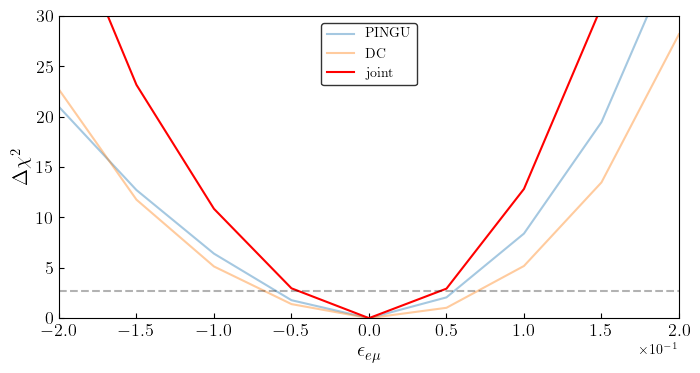

In [16]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
DC_marginalized_eem  = marginalize_DC(H1_DC,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'eem', sigma_a,sigma_b, f_DC)

PINGU_marginalized_eem = marginalize_PINGU(H1_PINGU,H0_PINGU,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'eem', sigma_a,sigma_b, f_PINGU)
joint_marginalized_eem = joint_deltachi[best_dm31_index,best_th23_index,best_ett_index,best_emt_index,:,best_eet_index]

ax.plot(eem_range, PINGU_marginalized_eem,label='PINGU', alpha=0.4)
ax.plot(eem_range, DC_marginalized_eem,label='DC', alpha=0.4)
ax.plot(eem_range, joint_marginalized_eem,label='joint', color='red')
ax.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')

ax.set_ylim(bottom=0, top =30)
ax.set_xlim(-2e-1,2e-1)
#plt.xlim((emt_range.min(), emt_range.max()))
ax.set_xlabel(r'$\epsilon_{e\mu}$', fontsize=15)
ax.set_ylabel(r'$\Delta \chi^2$', fontsize=15)
ax.tick_params(labelsize=13)
leg = plt.legend()
leg.get_frame().set_edgecolor('k')
ax.tick_params(axis='both', direction='in', which='both')
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
#save(fig, 'joint_3D_eem')

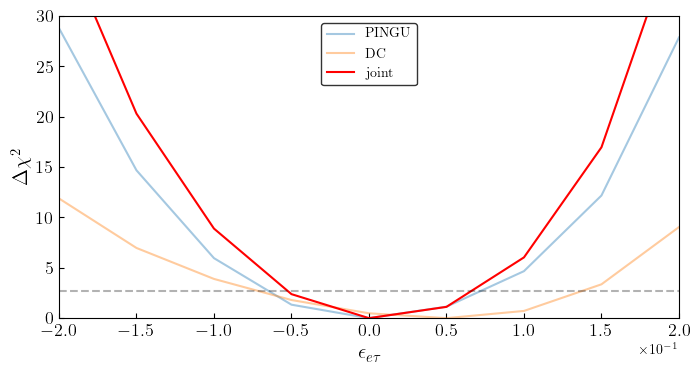

In [21]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
DC_marginalized_eet  = marginalize_DC(H1_DC,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'eet', sigma_a,sigma_b, f_DC)

PINGU_marginalized_eet = marginalize_PINGU(H1_PINGU,H0_PINGU,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'eet', sigma_a,sigma_b, f_PINGU)
joint_marginalized_eet = joint_deltachi[best_dm31_index,best_th23_index,best_ett_index,best_emt_index,best_eem_index,:]

ax.plot(eet_range, PINGU_marginalized_eet,label='PINGU', alpha=0.4)
ax.plot(eet_range, DC_marginalized_eet,label='DC', alpha=0.4)
ax.plot(eet_range, joint_marginalized_eet,label='joint', color='red')
ax.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')

ax.set_ylim(bottom=0, top =30)
ax.set_xlim(-2e-1,2e-1)
#plt.xlim((emt_range.min(), emt_range.max()))
ax.set_xlabel(r'$\epsilon_{e\tau}$', fontsize=15)
ax.set_ylabel(r'$\Delta \chi^2$', fontsize=15)
ax.tick_params(labelsize=13)
leg = plt.legend()
leg.get_frame().set_edgecolor('k')
ax.tick_params(axis='both', direction='in', which='both')
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
#save(fig, 'joint_3D_eet')

<ipython-input-61-489f2f5cb7c2>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=ax.set_xticklabels(labels=np.round(emt_range,3))
<ipython-input-61-489f2f5cb7c2>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=ax.set_yticklabels(labels=np.round(emm_range,3))


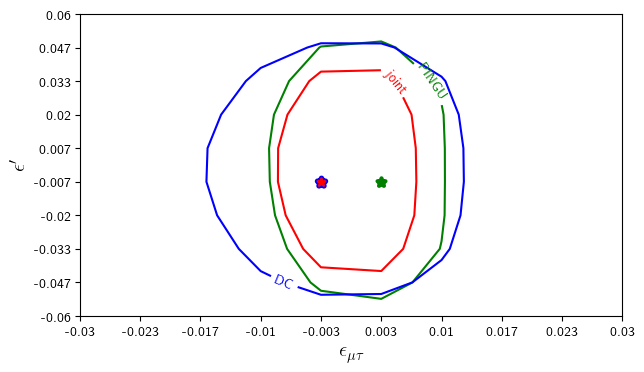

In [61]:
sandhya_emt = (-0.0043,0.0047)
sandhya_emm = (-0.03,0.017)

PINGU_deltachi_reshaped = PINGU_deltachi.reshape((len(emm_range), len(emt_range)))
DC_deltachi_reshaped = DC_deltachi.reshape((len(emm_range), len(emt_range)))
joint_deltachi_reshaped = (chibar - chibar.min()).reshape((len(emm_range), len(emt_range)))

best_fit_coords_PINGU = np.unravel_index(best_fit_index_PINGU,(len(emm_range),len(emt_range)))
best_fit_coords_DC = np.unravel_index(best_fit_index_DC,(len(emm_range),len(emt_range)))

best_fit_index_joint = np.argmin(joint_deltachi_reshaped)
best_fit_coords_joint = np.unravel_index(best_fit_index_joint,(len(emm_range),len(emt_range)))

fig, ax = plt.subplots(1,1, figsize=(7,4))
PINGU = ax.contour(PINGU_deltachi_reshaped.T,levels = [chi2.ppf(q=0.9, df = 2)], colors='green')
DC = ax.contour(DC_deltachi_reshaped.T,levels = [chi2.ppf(q=0.9, df = 2)],colors='blue')
joint = ax.contour(joint_deltachi_reshaped.T,levels = [chi2.ppf(q=0.9, df = 2)],colors='red')

ax.scatter(best_fit_coords_PINGU[0],best_fit_coords_PINGU[1], marker='*', color='green',lw=3)
ax.scatter(best_fit_coords_DC[0],best_fit_coords_DC[1], marker='*', color='blue', lw=4)
ax.scatter(best_fit_coords_joint[0],best_fit_coords_joint[1], marker='*', color='red', lw=1.5)
_=ax.set_xticklabels(labels=np.round(emt_range,3))
_=ax.set_yticklabels(labels=np.round(emm_range,3))
ax.set_xlabel(r'$\epsilon_{\mu\tau}$', fontsize=15)
ax.set_ylabel(r'$\epsilon^\prime$', fontsize=15)


fmt_PINGU = {}
strs = ['PINGU']#,'f = 5 \%']
for l, s in zip(PINGU.levels, strs):
    fmt_PINGU[l] = s

fmt_DC = {}
strs = ['DC']
for l, s in zip(DC.levels, strs):
    fmt_DC[l] = s

fmt_joint = {}
strs = ['joint']
for l, s in zip(DC.levels, strs):
    fmt_joint[l] = s

ax.clabel(PINGU, PINGU.levels, inline=True, fmt=fmt_PINGU, fontsize=10)
ax.clabel(DC, DC.levels, inline=True, fmt=fmt_DC, fontsize=10)
ax.clabel(joint, joint.levels, inline=True, fmt=fmt_joint, fontsize=10)
fig.savefig('latex/article/figures/emm_emp_contour.pdf')
from subprocess import call 
_ = call('pdfcrop latex/article/figures/emm_emp_contour.pdf latex/article/figures/emm_emp_contour.pdf')

hard-coded nsi_ranges
PINGU
$\epsilon_{\tau\tau}$
90CL: [-0.033]
3sigma: [-0.048]

DC
$\epsilon_{\tau\tau}$
90CL: [-0.029  0.045]
3sigma: []

joint
$\epsilon_{\tau\tau}$
90CL: [-0.028  0.043]
3sigma: [-0.043]

PINGU
$\epsilon_{\mu\tau}$
90CL: [-0.007  0.007]
3sigma: [-0.011  0.013]

DC
$\epsilon_{\mu\tau}$
90CL: [-0.015  0.005]
3sigma: [0.015]

joint
$\epsilon_{\mu\tau}$
90CL: [-0.007  0.005]
3sigma: [-0.011  0.01 ]

PINGU
$\epsilon_{e\mu}$
90CL: [-0.062  0.057]
3sigma: [-0.122  0.103]

DC
$\epsilon_{e\mu}$
90CL: [-0.072  0.075]
3sigma: [-0.132  0.127]

joint
$\epsilon_{e\mu}$
90CL: [-0.048  0.048]
3sigma: [-0.09   0.085]

PINGU
$\epsilon_{e\tau}$
90CL: [-0.069  0.077]
3sigma: [-0.121  0.133]

DC
$\epsilon_{e\tau}$
90CL: [-0.074  0.141]
3sigma: [-0.174  0.2  ]

joint
$\epsilon_{e\tau}$
90CL: [-0.054  0.072]
3sigma: [-0.101  0.118]

<ipython-input-46-9e3adb5db539>:60: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout

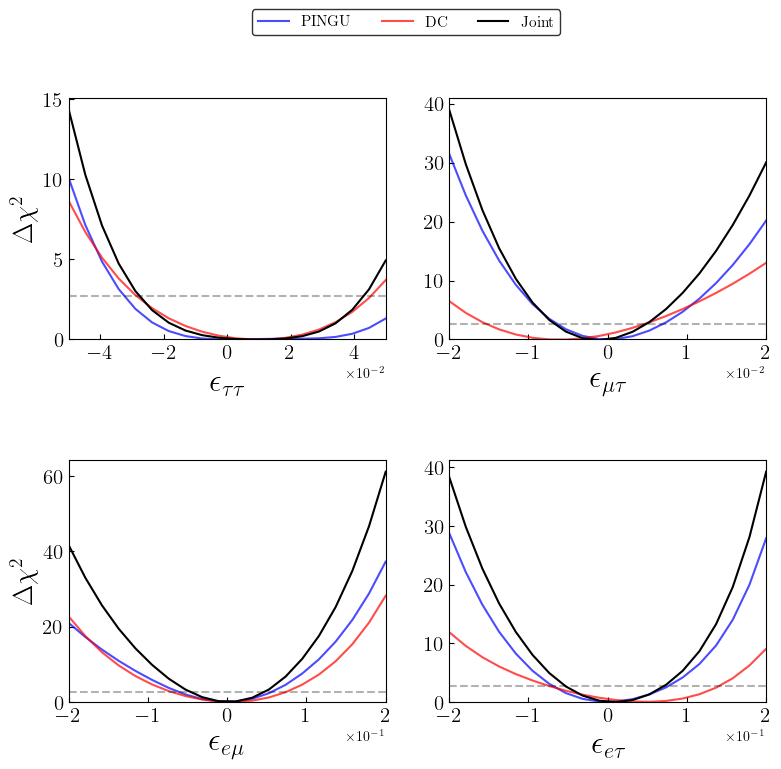

In [46]:
DC_marg_NO = [DC_marginalized_ett,DC_marginalized_emt,DC_marginalized_eem,DC_marginalized_eet]
PINGU_marg_NO = [PINGU_marginalized_ett,PINGU_marginalized_emt,PINGU_marginalized_eem,PINGU_marginalized_eet]
joint_marg_NO = [joint_marginalized_ett,joint_marginalized_emt,joint_marginalized_eem,joint_marginalized_eet]
nsi_param_range = [np.linspace(-5e-2,5e-2,9),np.linspace(-2e-2,2e-2,9), np.linspace(-2e-1,2e-1,9), np.linspace(-2e-1,2e-1,9)]

print('hard-coded nsi_ranges')
fig, ax = plt.subplots(2,2,figsize=(9,8), constrained_layout=True)
ax = ax.flatten()
demidov_ett = (-0.055, 0.056)
demidov_emt = (-0.023, 0.016)
demidov_eem = (-0.21, 0.20)
demidov_eet = (-0.19, 0.20)
xlabels = [r'$\epsilon_{\tau\tau}$', r'$\epsilon_{\mu\tau}$', r'$\epsilon_{e\mu}$', r'$\epsilon_{e\tau}$']
demidovs =[demidov_ett, demidov_emt, demidov_eem, demidov_eet]
for i in range(4):
    finer_e_range = np.linspace(nsi_param_range[i].min(),nsi_param_range[i].max(),20)
    interpolated_PINGU = splev(np.linspace(nsi_param_range[i].min(),nsi_param_range[i].max(),20),splrep(nsi_param_range[i], PINGU_marg_NO[i]))
    interpolated_DC = splev(np.linspace(nsi_param_range[i].min(),nsi_param_range[i].max(),20),splrep(nsi_param_range[i], DC_marg_NO[i]))
    interpolated_joint = splev(np.linspace(nsi_param_range[i].min(),nsi_param_range[i].max(),20),splrep(nsi_param_range[i], joint_marg_NO[i]))

    ax[i].plot(finer_e_range, interpolated_PINGU, label='PINGU', alpha=0.7, c='b', lw=1.5)
    ax[i].plot(finer_e_range, interpolated_DC, label='DC', alpha=0.7, c='r', lw=1.5)
    ax[i].plot(finer_e_range, interpolated_joint, label='Joint', color='k', lw=1.5)
    '''
    ax[i].plot(nsi_param_range[i], PINGU_marg_NO[i], label='PINGU', alpha=0.4, c='b', lw=1)
    ax[i].plot(nsi_param_range[i], DC_marg_NO[i], label='DC', alpha=0.4, c='g', lw=1)
    ax[i].plot(nsi_param_range[i], joint_marg_NO[i], label='Joint', color='k', lw=1)
    '''

    ax[i].axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')

    #ax[i].axvline(demidovs[i][0], alpha=0.6,c='black', label=r'Demidov NO')
    #ax[i].axvline(demidovs[i][1], alpha=0.6,c='black')
    ax[i].set_ylim(bottom=0)
    ax[i].set_xlim((nsi_param_range[i].min(), nsi_param_range[i].max()))
    ax[i].set_xlabel(xlabels[i], fontsize=23)
    ax[i].tick_params(labelsize=15,axis='both', direction='in', which='both')
    ax[i].ticklabel_format(axis="x", style="sci", scilimits=(0,0))

    cl_90_bounds_PINGU = splrep(nsi_param_range[i], PINGU_marg_NO[i]- chi2.ppf(0.9,1))
    three_sigma_bounds_PINGU = splrep(nsi_param_range[i], PINGU_marg_NO[i]- chi2.ppf(0.9973,1))

    cl_90_bounds_DC = splrep(nsi_param_range[i], DC_marg_NO[i]- chi2.ppf(0.9,1))
    three_sigma_bounds_DC = splrep(nsi_param_range[i], DC_marg_NO[i]- chi2.ppf(0.9973,1))

    cl_90_bounds_joint = splrep(nsi_param_range[i], joint_marg_NO[i]- chi2.ppf(0.9,1))
    three_sigma_bounds_joint = splrep(nsi_param_range[i], joint_marg_NO[i]- chi2.ppf(0.9973,1))
    print('PINGU')
    print(xlabels[i]+'\n'+f'90CL: {sproot(cl_90_bounds_PINGU)}\n'+f'3sigma: {sproot(three_sigma_bounds_PINGU)}\n')
    print('DC')
    print(xlabels[i]+'\n'+f'90CL: {sproot(cl_90_bounds_DC)}\n'+f'3sigma: {sproot(three_sigma_bounds_DC)}\n')
    print('joint')
    print(xlabels[i]+'\n'+f'90CL: {sproot(cl_90_bounds_joint)}\n'+f'3sigma: {sproot(three_sigma_bounds_joint)}\n')

ax[0].set_ylabel(r'$\Delta \chi^2$', fontsize=20)
ax[2].set_ylabel(r'$\Delta \chi^2$', fontsize=20)
handles, labels = ax[1].get_legend_handles_labels()
leg= fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1),fontsize=11)
leg.get_frame().set_edgecolor('k')
plt.subplots_adjust(hspace=0.5)
plt.savefig('./article/figures/joint_3D_NO.pdf', bbox_inches="tight")
#save(fig, 'joint_3D_NO') #Doesnt work, legend removed
#savethesis(fig, 'joint_3D_NO')#Doesnt work, legend removed